# Import

In [1]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from scipy.stats import loguniform
import pickle

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

#x_ticks
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['xtick.major.pad'] = 10

#y_ticks
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.left'] = True 
plt.rcParams['ytick.labelleft'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.labelsize'] = 20

#general
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['figure.autolayout'] = True
plt.rcParams['animation.html'] = 'jshtml'

Import required functions/classes from "src" folder.

In [4]:
from src.dataset_generation import generate_wells, plot_wells, generate_perm_from_map, generate_perm
from src.semi_analytical_reservoir_model.properties import PropertiesClass
from src.semi_analytical_reservoir_model.solver import run_func
from src.automated_interpretation.mass_interpretation import single_interpretation, mass_interpretation
from src.automated_interpretation.direct_solver import direct_problem_solution
from src.inverse_problem import InverseProblemSolution

# Synthetic dataset generation

The procedure is described in Section 4 of the paper.

## Input data for ANN

Synthetic reservoir with dimensions 4 km * 4 km. 

Grid points where the wells can be randomly placed provided that the minimal distance between any two wells equals the prescribed value $\Delta d$.

In [5]:
x_array_input = np.linspace(-2000, 2000, 249)

Demonstration of the random well placement corresponding to $\Delta d$ = 500 m.

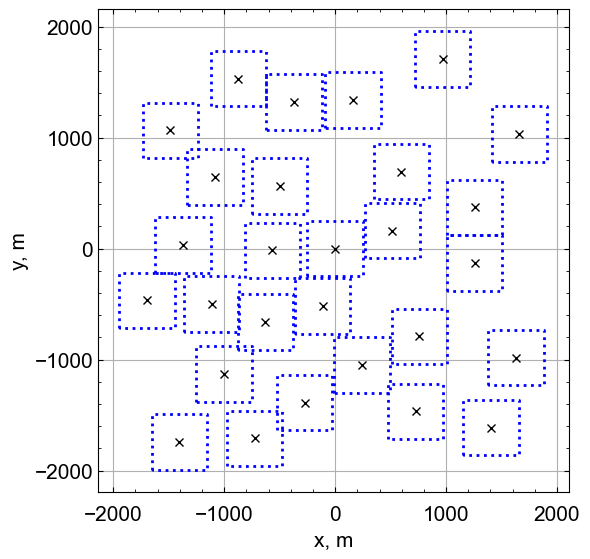

In [6]:
array_wells = generate_wells(x_array_input, 500)
plot_wells(array_wells)

Example of the permeability distribution around a well. Contributions from the well itself, neighbours and its approximation by quadratic polynomial.

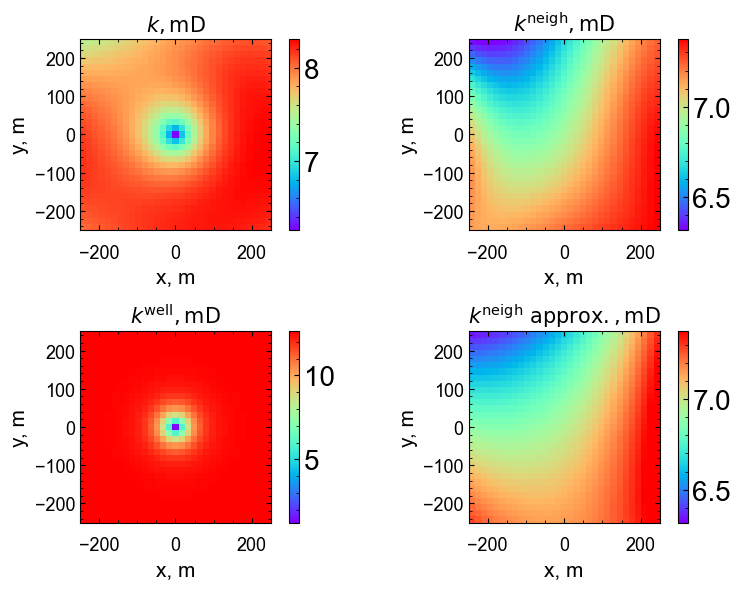

In [7]:
generate_perm_from_map(array_wells, x_array_input, 31*31, None, None, True);

Generation of 10 permeability distributions in a square 500 m * 500 m around a vertical well.
We save INC files to MUFITS with permeability field (keyword PERMX) in the folder "data/synthetic_dataset/perm_inc_files".
Moreover, we put a file "ann_input_data.npy" with an numpy array containing parameters characterizing permeability distribution in folder "data/synthetic_dataset/". 

In [8]:
num_samples = 10
generate_perm(x_array_input, 31 * 31, num_samples + 1)

In [9]:
input_data = np.load('data/synthetic_dataset/ann_input_data.npy')
print('shape = ', input_data.shape)
print('example of a sample:\n', input_data[0])

shape =  (10, 14)
example of a sample:
 [ 2.04078704e+02  1.54694340e+01  1.94294283e+00  1.44516610e+00
  7.74188601e-01  1.31855916e-01  1.49421143e+01  1.06759301e+01
 -1.49738948e-06 -1.89185071e-06  2.96375694e-07  5.70383416e-04
 -2.56314024e-04  8.36867976e+00]


## Output data for ANN

### Input parameters of a reservoir model

Firstly, we demonstrate an example corresponding to uniform reservoir permeability equals 10 mD.

In [10]:
num_points = 100

time_start, time_end = 1e-3, 180 * 24 # h

time_array = np.logspace(np.log10(time_start), np.log10(time_end), num_points)

flow_rate = 20 # m3/d

mu = 2.5 # cP
b = 1.2
ct = 2e-4 * 1.01325 # 1/atm

k = 10 # mD

phi = 0.15
p_init = 250 / 1.01325 # atm

rw = 0.1 # m
skin = 0

portion_x, portion_y, portion_z = 0.5, 0.5, 0.5
xe, ye, ze = 500, 500, 10 # m
xbound, ybound = "c", "c"
zbound_up, zbound_down = "n", "n"

params = PropertiesClass(time_array, flow_rate, mu, b, ct, k, phi, p_init, rw, 
                         portion_x, portion_y, xe, ye, ze, xbound, ybound, skin)

### Single drawdown test: semi-analytical solution vs numerical solution. Example of interpretation.

#### Comparison of bottomhole pressure (BHP) dynamics calculated by semi-analytical (in-house) and numerical (MUFITS) reservoir models.

Installation guide and reference manual of the reservoir simulator MUFITS: http://mufits.org/documentation.html.

Folder "MUFITS_models/vertical_well_single_calc": for BHP calculation, please, use "H64.BAT" file, where it is required to put paths to exe-files of MUFITS simulator (H64.EXE) and MPI.

The input file for MUFITS is "MODEL.RUN".

In [11]:
# run semi-analytical model
bhp_sa = run_func(params)

# read file with MUFITS calculation
data_mufits = np.array(pd.read_csv("MUFITS_models/vertical_well_single_calc/MODEL.WELL.PRODUCER.CSV"))

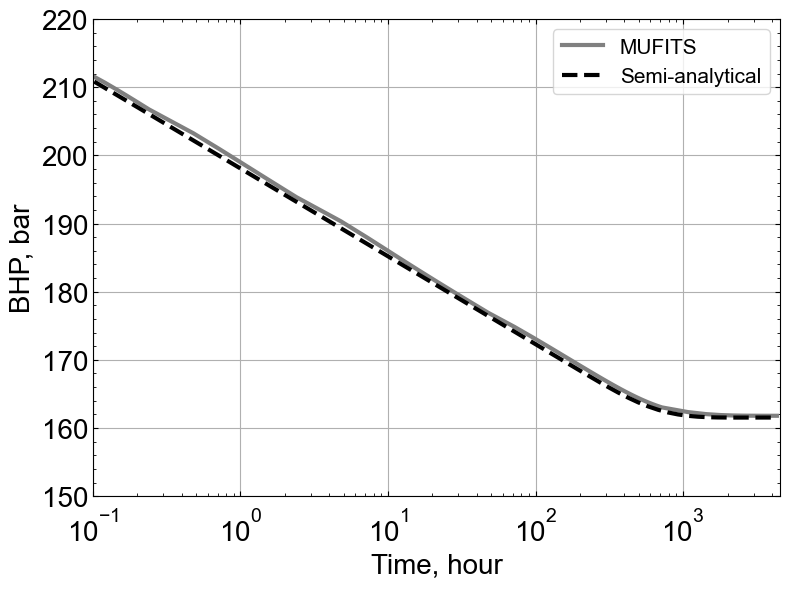

In [12]:
plt.figure(figsize=(8, 6))

plt.plot(data_mufits[:, 0] * 24, data_mufits[:, 1], linewidth=3, label='MUFITS', color='grey')
plt.plot(time_array, bhp_sa * 1.01325, linewidth=3, color='black', linestyle='--', label='Semi-analytical')

plt.xlabel('Time, hour', fontsize=20)
plt.ylabel('BHP, bar', fontsize=20)

plt.xlim(0.1, )
plt.ylim(150, 220)
plt.xscale('log')

plt.legend(frameon=True, fontsize=15)
plt.grid()

plt.show()

#### Drawdown test interpretation

Using numerical BHP, we compute the integral permeability and skin. In the present case, the former should be 10 mD, while latter is 0.

In [13]:
time_mufits, bhp_mufits = data_mufits[3:, 0] * 24, data_mufits[3:, 1] / 1.01325

time_start_1 = 0.1 # h
num_points_1 = 30

time_array_1 = np.logspace(np.log10(time_start_1), np.log10(time_end), num_points_1)

params_dict = {
    'time_array': time_array_1, 'flow_rate': flow_rate, 
    'mu': mu, 'b': b, 'ct': ct,
    'phi': phi,
    'p_init': p_init,
    'rw': rw, 
    'portion_x': portion_x, 'portion_y': portion_y,
    'xe': xe, 'ye': ye, 'ze': ze,
    'xbound': xbound, 'ybound': ybound
}

target_names = ['k', 'skin']

x0 = [5, 1]

res_interpr = single_interpretation(bhp_mufits, None, time_mufits, time_array_1, target_names, params_dict, x0)
print(f"k = {res_interpr[0]:.4f}, S = {res_interpr[1]:.4f}")

k = 9.9212, S = -0.1048


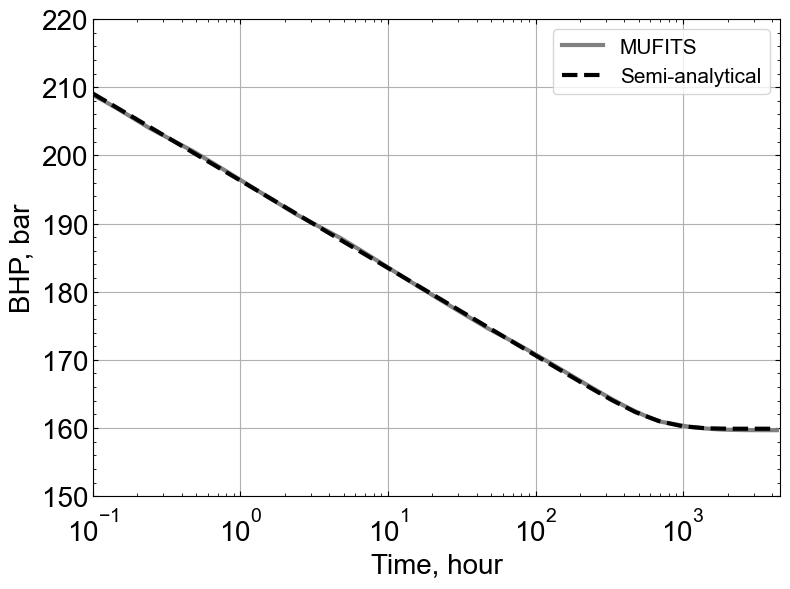

In [14]:
bhp_calc, _ = direct_problem_solution(res_interpr, target_names, params_dict, 0, True)

plt.figure(figsize=(8, 6))

plt.plot(time_mufits, bhp_mufits, linewidth=3, label='MUFITS', color='grey')
plt.plot(time_array_1, bhp_calc, linewidth=3, color='black', linestyle='--', label='Semi-analytical')

plt.xlabel('Time, hour', fontsize=20)
plt.ylabel('BHP, bar', fontsize=20)

plt.xlim(0.1, )
plt.ylim(150, 220)
plt.xscale('log')

plt.legend(frameon=True, fontsize=15)
plt.grid()

plt.show()

## Mass drawdown tests

Using permeability distributions computed in Section 2.1 of the notebook, we perform numertical drawdown tests.

Folder "MUFITS_models/vertical_well_multiple_calc/U": for mass BHP calculation, please, use "U.BAT" file, where it is required to put path to exe-file of MUFITS utilities program (U64.EXE).

Folder "MUFITS_models/vertical_well_multiple_calc": in "MODEL_MASS_CALC.RUN", please, put paths to exe-files of MUFITS simulator (H64.EXE) and MPI. Moreover, the number of data samples in keyword SEARCH should be specified (in the current experiement, we put 10, since in Section 2.1 of the notebook, we generate 10 samples). 

The input file for MUFITS, template file for mass calculations, is "MODEL.TEMPLATE".

After calculating the values of integral permeability and skin factor, we combine them with the parameters characterizing the permeability distribution (input parameters for ANN) and save into file "ann_input_output_data.npy" in the folder "data/synthetic_dataset".

In [15]:
file_name_mufits = 'MUFITS_models/vertical_well_multiple_calc/U/OPTIM.MODEL.RPT'
file_name_params = 'data/synthetic_dataset/ann_input_data.npy'
path_save = 'data/synthetic_dataset/ann_input_output_data.npy'

time_mufits = np.cumsum(np.array(10 * [0.001] + 9 * [0.01] + 19 * [0.1] + 28 * [1] + 10 * [15])) * 24

time_start_1 = 0.1 # h
num_points_1 = 30

time_array_1 = np.logspace(np.log10(time_start_1), np.log10(time_end), num_points_1)

params_dict = {
    'time_array': time_array_1, 'flow_rate': flow_rate, 
    'mu': mu, 'b': b, 'ct': ct,
    'phi': phi,
    'p_init': p_init,
    'rw': rw, 
    'portion_x': portion_x, 'portion_y': portion_y,
    'xe': xe, 'ye': ye, 'ze': ze,
    'xbound': xbound, 'ybound': ybound
}

target_names = ['k', 'skin']

mass_interpretation(file_name_mufits, file_name_params, path_save,
                    time_mufits, time_array_1, target_names, params_dict)

In [16]:
input_output_data = np.load('data/synthetic_dataset/ann_input_output_data.npy')
print('shape = ', input_output_data.shape)
print('example of a sample:\n', input_output_data[0])

shape =  (10, 16)
example of a sample:
 [ 2.04078704e+02  1.54694340e+01  1.94294283e+00  1.44516610e+00
  7.74188601e-01  1.31855916e-01  1.49421143e+01  1.06759301e+01
 -1.49738948e-06 -1.89185071e-06  2.96375694e-07  5.70383416e-04
 -2.56314024e-04  8.36867976e+00  8.96499011e+00 -3.37529384e-01]


# Artificial Neural Network

Details related to ANN are given in Section 4 of the paper.

##  Data preprocessing

The file 'data/synthetic_dataset/ann_input_output_data.npy' created in Section 2.3 of the notebook, can be used for ANN training if the number of samples is large. However, in the current notebook, we generate 10 samples only, and it is insufficient. That is why, we additionally upload the dataset 'data/synthetic_dataset/ann_input_output_data_paper.npy' using in the paper and consisting of about 40.000 points.

In [17]:
# please, uncomment, if you would like to use "ann_input_output_data.npy" file
# data = np.load('data/synthetic_dataset/ann_input_output_data.npy')

data = np.load('data/synthetic_dataset/ann_input_output_data_paper.npy')

Separate input and output parameters:

In [18]:
X, y = data[:, :-2], data[:, [-2, -1]]
print(X.shape, y.shape)

(39812, 14) (39812, 2)


Data samples split between train and test:

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(f'train samples = {X_train.shape[0]}, test samples = {X_test.shape[0]}')

train samples = 35830, test samples = 3982


Cross-validation procedure:

In [20]:
cv = KFold(n_splits=3, shuffle=True, random_state=42)

## Hyperparameters tuning. Model performance estimation.

ANN implementation in scikit-learn:

In [21]:
MLR = MLPRegressor(hidden_layer_sizes=(64, 128, 64), learning_rate= 'adaptive', 
                   max_iter=10000, early_stopping=True, random_state=42)
MLP_pipeline = Pipeline([("scaler", StandardScaler()), ('mlp_regressor', MLR)])

We choose the following values/value ranges for hyperparameters batch size, initial learning rate, and prefactor before regularization term:

In [22]:
param_distributions = {
    "mlp_regressor__batch_size": [32, 64, 128, 256, 512],
    "mlp_regressor__learning_rate_init": loguniform(1e-4, 1e-1), 
    'mlp_regressor__alpha': loguniform(1e-6, 1)
}

In the notebook, we take the number of interations, n_iter, equal to 5. However, it should much larger. In the paper, we used 1000.

In [23]:
rnd_search = RandomizedSearchCV(MLP_pipeline, param_distributions, n_iter=5, 
                                scoring="neg_mean_absolute_error", \
                                n_jobs=-1, cv=cv, return_train_score=True)

In [24]:
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('mlp_regressor',
                                              MLPRegressor(early_stopping=True,
                                                           hidden_layer_sizes=(64,
                                                                               128,
                                                                               64),
                                                           learning_rate='adaptive',
                                                           max_iter=10000,
                                                           random_state=42))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'mlp_regressor__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000027D633A7B80>,
                                        'mlp_regressor__batch_size': [32, 64,
                                                                      128, 256,
                                                                      512],
                                        'mlp_regressor__learning_rate_init': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000027D65CC29D0>},
                   return_train_score=True, scoring='neg_mean_absolute_error')

Model with the best performance:

In [25]:
rnd_search.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp_regressor',
                 MLPRegressor(alpha=0.06350772036748165, batch_size=256,
                              early_stopping=True,
                              hidden_layer_sizes=(64, 128, 64),
                              learning_rate='adaptive',
                              learning_rate_init=0.0036094464172845594,
                              max_iter=10000, random_state=42))])

When we took n_iter equal to 1000, we obtained the following optimal values of the hyperparameters:

In [26]:
MLP_pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp_regressor',
                 MLPRegressor(alpha=0.044321004551788945, batch_size=32,
                              early_stopping=True,
                              hidden_layer_sizes=(64, 128, 64),
                              learning_rate='adaptive',
                              learning_rate_init=0.0002834060598357831,
                              max_iter=10000, random_state=42))])

In [27]:
MLP_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp_regressor',
                 MLPRegressor(alpha=0.044321004551788945, batch_size=32,
                              early_stopping=True,
                              hidden_layer_sizes=(64, 128, 64),
                              learning_rate='adaptive',
                              learning_rate_init=0.0002834060598357831,
                              max_iter=10000, random_state=42))])

In [28]:
y_pred_train = MLP_pipeline.predict(X_train)
y_pred = MLP_pipeline.predict(X_test)

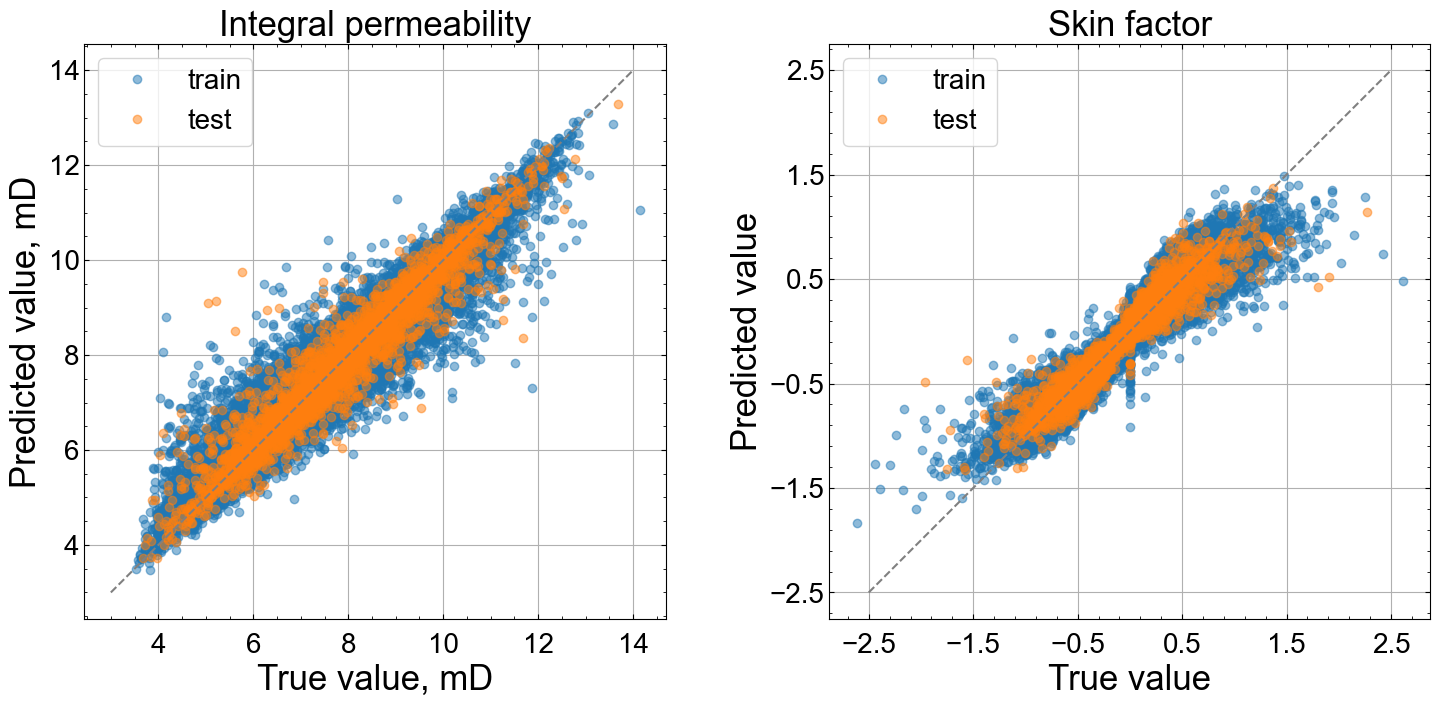

In [29]:
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.plot(y_train[:, 0], y_pred_train[:, 0], linestyle='', marker='o', alpha=0.5, label='train')
plt.plot(y_test[:, 0], y_pred[:, 0], linestyle='', marker='o', alpha=0.5, label='test')
plt.plot([3, 14], [3, 14], color='grey', linestyle='--')
plt.title('Integral permeability', fontsize=25)
plt.xlabel('True value, mD', fontsize=25)
plt.ylabel('Predicted value, mD', fontsize=25)
plt.legend(frameon=True, fontsize=20)
plt.xlim(2, 14)
plt.ylim(2, 14)
plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.axis('scaled')
plt.grid()

plt.subplot(1, 2, 2)

plt.plot(y_train[:, 1], y_pred_train[:, 1], linestyle='', marker='o', alpha=0.5, label='train')
plt.plot(y_test[:, 1], y_pred[:, 1], linestyle='', marker='o', alpha=0.5, label='test')
plt.plot([-2.5, 2.5], [-2.5, 2.5], color='grey', linestyle='--')
plt.title('Skin factor', fontsize=25)
plt.xlabel('True value', fontsize=25)
plt.ylabel('Predicted value', fontsize=25)
plt.legend(frameon=True, fontsize=20)
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.xticks(ticks=np.arange(-2.5, 3, 1))
plt.yticks(ticks=np.arange(-2.5, 3, 1))
plt.axis('scaled')
plt.grid()

plt.show()

In [31]:
param_name = ['Integral permeability', 'Skin']
for item in [0, 1]:
    print(f'{param_name[item]}:')
    print(f'train scores: MAE = {mean_absolute_error(y_train[:, item], y_pred_train[:, item]):.3f}, ' + 
          f'MSE = {mean_squared_error(y_train[:, item], y_pred_train[:, item]):.3f}, ' + 
          f'R2 = {r2_score(y_train[:, item], y_pred_train[:, item]):.3f}')

    print(f'test scores: MAE = {mean_absolute_error(y_test[:, item], y_pred[:, item]):.3f}, ' + 
          f'MSE = {mean_squared_error(y_train[:, item], y_pred_train[:, item]):.3f}, ' + 
          f'R2 = {r2_score(y_test[:, item], y_pred[:, item]):.3f}')

Integral permeability:
train scores: MAE = 0.250, MSE = 0.153, R2 = 0.931
test scores: MAE = 0.256, MSE = 0.153, R2 = 0.924
Skin:
train scores: MAE = 0.080, MSE = 0.016, R2 = 0.909
test scores: MAE = 0.081, MSE = 0.016, R2 = 0.901


In [32]:
MLP_pipeline.fit(X, y);

We save ANN into file 'ann.sav' into the folder 'data/ml_models'. We also upload ANN utilized in the paper in the same folder. Due to different scikit-learn versions, ANNs can provide slightly different estimations.

In [33]:
path_to_save = 'data/ml_models/ann.sav'
pickle.dump(MLP_pipeline, open(path_to_save, 'wb'))

In [34]:
MLP_pipeline = pickle.load(open(path_to_save, 'rb'))

# Inverse problem solution - The Egg Model

Section 3 of the paper outlines global model for reservoir permeability map construction.

Egg model is described in Section 5.

Solving the inverse problem, we obtain parameters $k^{\mathrm{near}}$, $k^{\mathrm{far}}$ corresponding to each well and parameters $\alpha, \beta, \gamma, \delta, r_d, r_g$ of kernel regression.

Permeability distribution is saved into INC file to MUFITS in "PERM_FIELD_APPROX.INC" located in the folder "data/EGG_model". In the same folder, we also save the optimized values of the paramers "optimized_params.npy" and estimated permeabilities, $k^{\mathrm{WL}}, k^{\mathrm{WT}}$, "perm_pred.npy".   

MUFITS input files with Egg Model can be found in the folder "MUFITS_models/EGG_model". Using the folder "initial_distribution", you can simulate production/injection profiles corresponding to the original permeability distribution, while the input file in the folder "approximate_distribution" takes permeability field from the file "PERM_FIELD_APPROX.INC". Additionally, you carry out modeling taking approximate permeability field obtained in the paper "PERM_FIELD_APPROX_PAPER.INC".    

In [35]:
path_egg_dataset = 'data/EGG_model/EGG_model_parameters.xlsx'

path_ml_model = 'data/ml_models/ann.sav'
# path_ml_model = 'data/ml_models/ann_paper.sav'

path_save_list = ['data/EGG_model/PERM_FIELD_APPROX.INC', 
                  'data/EGG_model/optimized_params.npy', 
                 'data/EGG_model/perm_pred.npy']

inverse_problem = InverseProblemSolution(path_egg_dataset, path_ml_model, path_save_list)

# you can put larger value of num_iter, e.g., 300
num_iter = 100
pred_values = inverse_problem(num_iter)

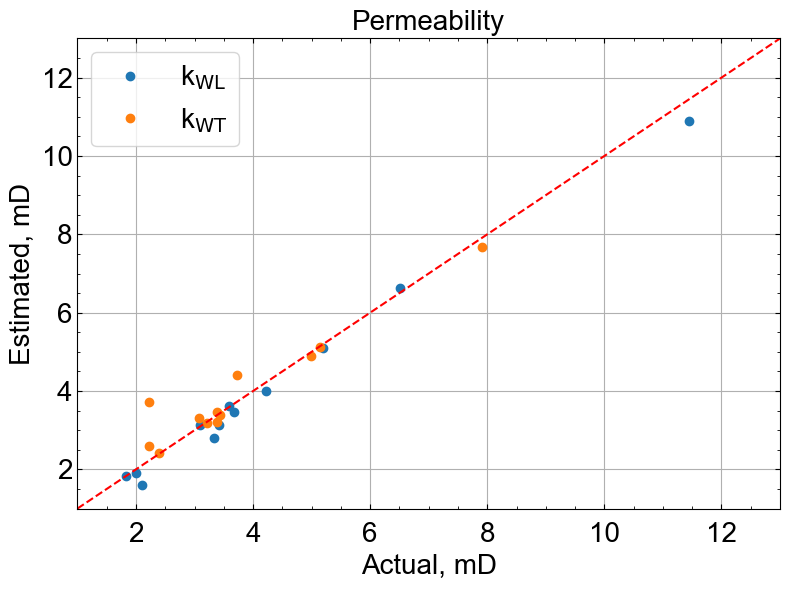

In [36]:
plt.figure(figsize=(8, 6))

plt.plot(inverse_problem.target_values[:, 0], pred_values[:, 0], marker='o', linestyle='', label=r'k$_{\mathrm{WL}}$')
plt.plot(inverse_problem.target_values[:, 1], pred_values[:, 1], marker='o', linestyle='', label=r'k$_{\mathrm{WT}}$')
plt.plot([1, 13], [1, 13], color='red', linestyle='--')

plt.xticks(np.arange(14)[::2])
plt.yticks(np.arange(14)[::2])

plt.xlim(1, 13)
plt.ylim(1, 13)

plt.title('Permeability', fontsize=20)
plt.xlabel('Actual, mD', fontsize=20)
plt.ylabel('Estimated, mD', fontsize=20)
plt.legend(frameon=True, fontsize=20)

plt.grid()
plt.show()

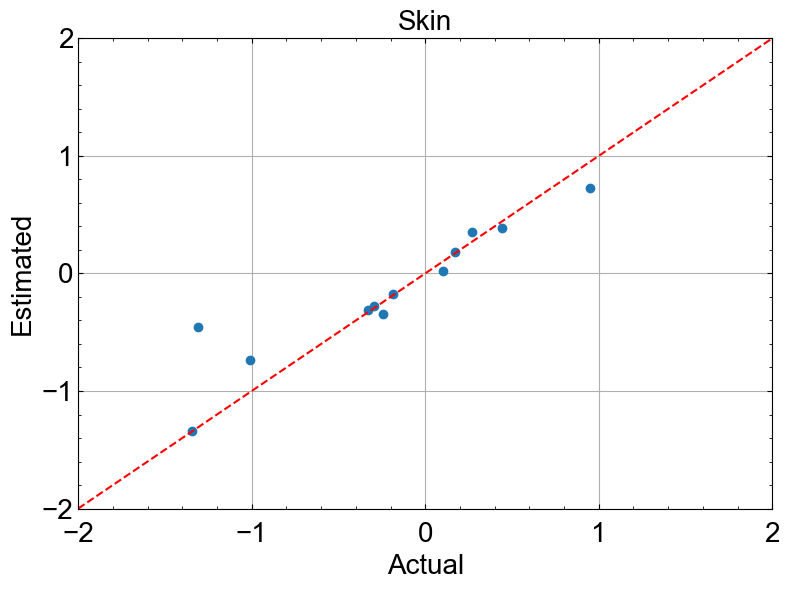

In [37]:
plt.figure(figsize=(8, 6))

plt.plot(inverse_problem.target_values[:, 2], pred_values[:, 2], marker='o', linestyle='')
plt.plot([-2, 2], [-2, 2], color='red', linestyle='--')

plt.title('Skin', fontsize=20)

plt.xlabel('Actual', fontsize=20)
plt.ylabel('Estimated', fontsize=20)

plt.xticks(np.arange(-2, 3))
plt.yticks(np.arange(-2, 3))

plt.xlim(-2, 2)
plt.ylim(-2, 2)

plt.grid()
plt.show()